### Setting project dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys

curr_path = !pwd
curr_path = curr_path[0] + "/"
curr_path

'/content/'

In [3]:
utils_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'cmpt420_project', 'src', 'utils/')
utils_path

'/content/drive/MyDrive/cmpt420_project/src/utils/'

In [4]:
sys.path.append(utils_path)

In [5]:
img_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'CelebA', 'Img', 'img_align_celeba.zip')
img_path

'/content/drive/MyDrive/CelebA/Img/img_align_celeba.zip'

In [6]:
data_path = os.path.join('/tmp', 'dataset/')
data_path

'/tmp/dataset/'

In [7]:
if (os.path.exists(data_path)) == False:
  !mkdir {data_path}

In [8]:
# import zipfile

if os.path.exists(os.path.join(os.path.dirname(data_path), 'img_align_celeba')) == False:
  !unzip {img_path} -d {data_path}


Streaming output truncated to the last 5000 lines.
 extracting: /tmp/dataset/img_align_celeba/197600.jpg  
 extracting: /tmp/dataset/img_align_celeba/197601.jpg  
 extracting: /tmp/dataset/img_align_celeba/197602.jpg  
 extracting: /tmp/dataset/img_align_celeba/197603.jpg  
 extracting: /tmp/dataset/img_align_celeba/197604.jpg  
 extracting: /tmp/dataset/img_align_celeba/197605.jpg  
 extracting: /tmp/dataset/img_align_celeba/197606.jpg  
 extracting: /tmp/dataset/img_align_celeba/197607.jpg  
 extracting: /tmp/dataset/img_align_celeba/197608.jpg  
 extracting: /tmp/dataset/img_align_celeba/197609.jpg  
 extracting: /tmp/dataset/img_align_celeba/197610.jpg  
 extracting: /tmp/dataset/img_align_celeba/197611.jpg  
 extracting: /tmp/dataset/img_align_celeba/197612.jpg  
 extracting: /tmp/dataset/img_align_celeba/197613.jpg  
 extracting: /tmp/dataset/img_align_celeba/197614.jpg  
 extracting: /tmp/dataset/img_align_celeba/197615.jpg  
 extracting: /tmp/dataset/img_align_celeba/197616.jpg

In [9]:
import torch
import numpy as np
from torch.utils.data import random_split, DataLoader, Subset
from DataLoader import CelebADataset

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyperparameters

In [11]:
SAMPLE_SEED = 42

BATCH_SIZE = 256

In [12]:
att_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'cmpt420_project', 'dataset', 'Anno', 'list_attr_celeba.txt')

dataset = CelebADataset(os.path.join(os.path.dirname(data_path), 'img_align_celeba'), att_path)

In [13]:
TOTAL_SIZE = len(dataset)
TOTAL_SIZE

202599

### Dataset Split

In [14]:
TEST_SIZE = int(0.1 * TOTAL_SIZE)
TRAIN_SIZE = TOTAL_SIZE - TEST_SIZE

# Generator
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# TODO: USE THIS FOR FULL TRAINING
# Data split
indices = torch.randperm(len(dataset))
ds_train, ds_test = random_split(dataset, [TRAIN_SIZE, TEST_SIZE], generator=generator)

print(f"Train size: {len(ds_train)}, Test size: {len(ds_test)}")

Train size: 182340, Test size: 20259


In [15]:
full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
len(full_loader), int(np.ceil(len(dataset)/BATCH_SIZE)) == len(full_loader)

(792, True)

In [16]:
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

### Loading Trained models

In [43]:
full_model = torch.load(f'/content/drive/MyDrive/full_model_04_07_2025_01_07.pth', weights_only=False).to(device)
vit_model = torch.load(f'/content/drive/MyDrive/vit_pruned04_07_2025_14_03.pth', weights_only=False).to(device)
pruned_model = torch.load(f'/content/drive/MyDrive/pruned_model_04_07_2025_01_07.pth', weights_only=False).to(device)

# CIE EDA

In [20]:
from ModelUtils import ModelUtils
mu = ModelUtils(device)

## Test Set

In [44]:
orig_test_cie = mu.get_cie_count(full_model, pruned_model, test_loader)

Determining CIEs:
Number of CIEs: 760


In [21]:
test_cie = mu.get_cie_count(full_model, vit_model, test_loader)

Determining CIEs:
Number of CIEs: 793


In [45]:
orig_cie_dataset = [sample for sample in dataset if sample[2] in orig_test_cie]
len(orig_cie_dataset) == len(orig_test_cie)

True

In [39]:
cie_dataset = [sample for sample in dataset if sample[2] in test_cie]
len(cie_dataset) == len(test_cie)

True

Loading Dataset

In [46]:
orig_cie_test_loader = DataLoader(orig_cie_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [40]:
cie_test_loader = DataLoader(cie_dataset, batch_size=BATCH_SIZE, shuffle=False)

### CIE Model Performance

### Full_model

Original CIE set

In [47]:
mu.test_model(full_model, orig_cie_test_loader)


Test Evaluation
Accuracy: 0.56
Test precision: 0.56
Test recall: 0.52
Test f1-score: 0.54
Finished test evaluation!


VIT CIE set

In [41]:
mu.test_model(full_model, cie_test_loader)

Test Evaluation
Accuracy: 0.55
Test precision: 0.55
Test recall: 0.42
Test f1-score: 0.48
Finished test evaluation!


### Pruned_model

In [48]:
mu.test_model(pruned_model, orig_cie_test_loader)

Test Evaluation
Accuracy: 0.44
Test precision: 0.45
Test recall: 0.48
Test f1-score: 0.46
Finished test evaluation!


### ViT Hybrid Model

In [42]:
mu.test_model(vit_model, cie_test_loader)

Test Evaluation
Accuracy: 0.45
Test precision: 0.45
Test recall: 0.58
Test f1-score: 0.51
Finished test evaluation!


Young: 604, Old: 189, Females: 668, Males: 125


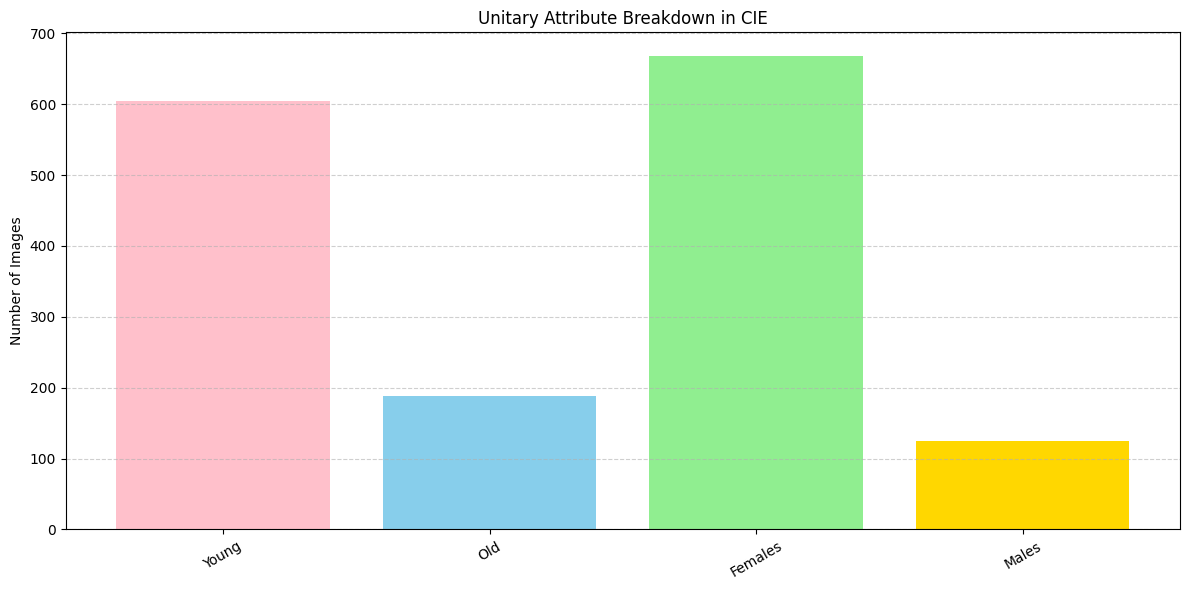

In [22]:
mu.show_cie_eda_unitary_plot(test_cie, att_path)

Young Females: 531, Young Males: 73, Old Males: 52, Old Females: 137


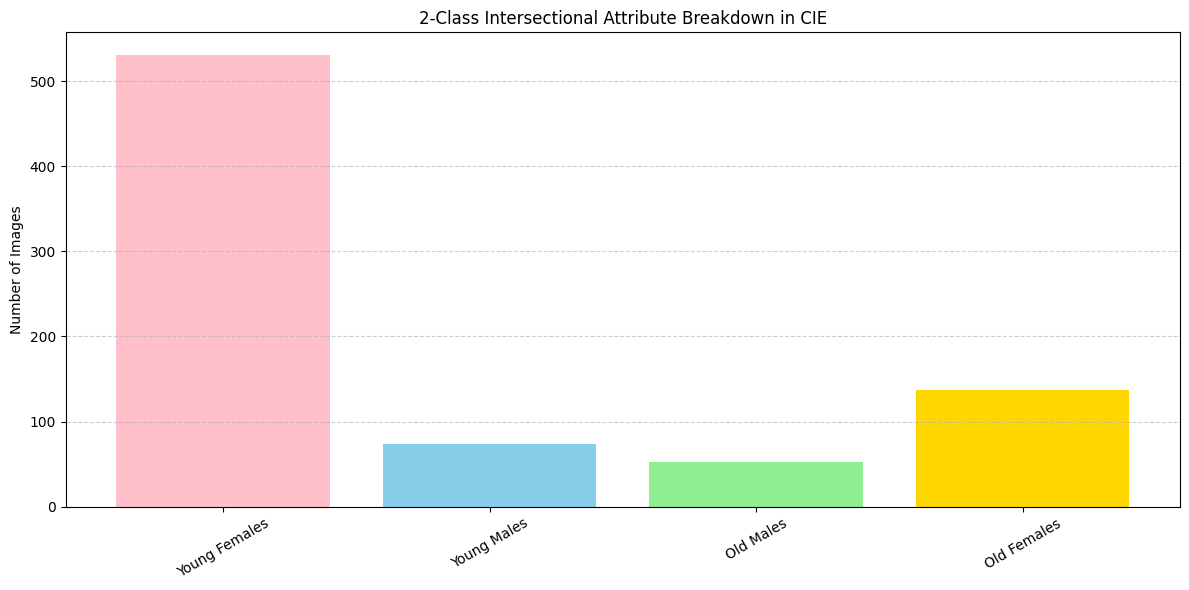

In [23]:
mu.show_cie_eda_inter_plot(test_cie, att_path)

Non-Blonde Young: NBY
Non-Blonde Female: NBF
Non-Blonde Male: NBM
Non-Blonde Old: NBO
Blonde Female: BF
Blonde Young: BY
Blonde Old: BO
Blonde Male: BM
NBY: 297, NBF: 321, NBM: 85, NBO: 109, BF: 347, BY: 307, BO: 80, BM: 40


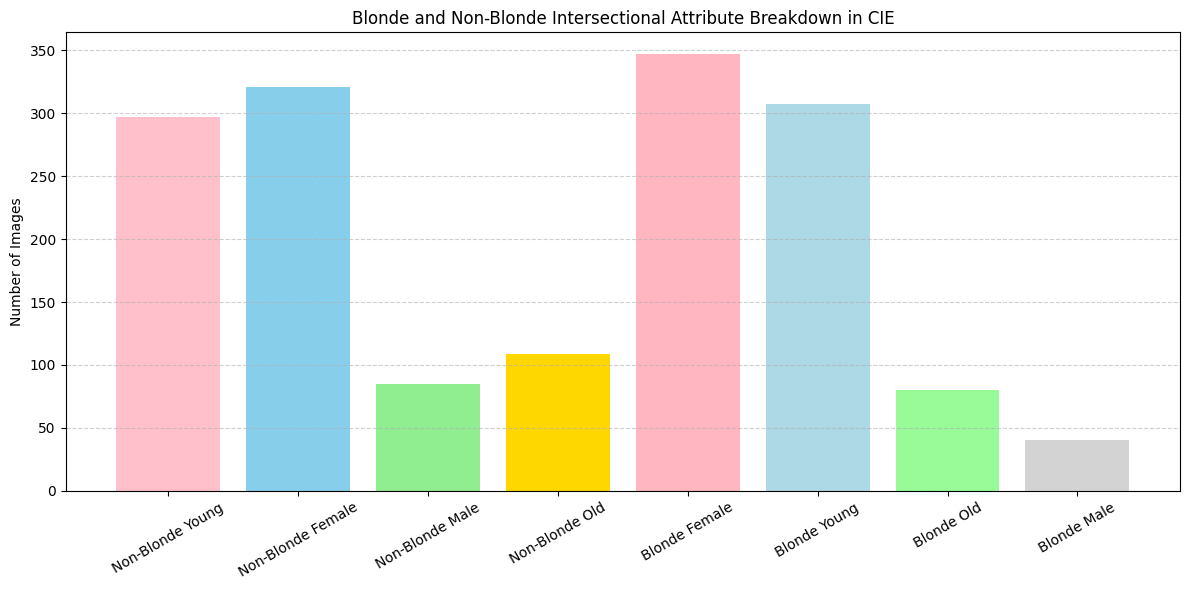

In [24]:
mu.show_cie_eda_blonde_inter_plot(test_cie, att_path)

## Train Set

In [25]:
train_cie = mu.get_cie_count(full_model, vit_model, train_loader)

Determining CIEs:
Number of CIEs: 2175


Young: 1680, Old: 495, Females: 1800, Males: 375


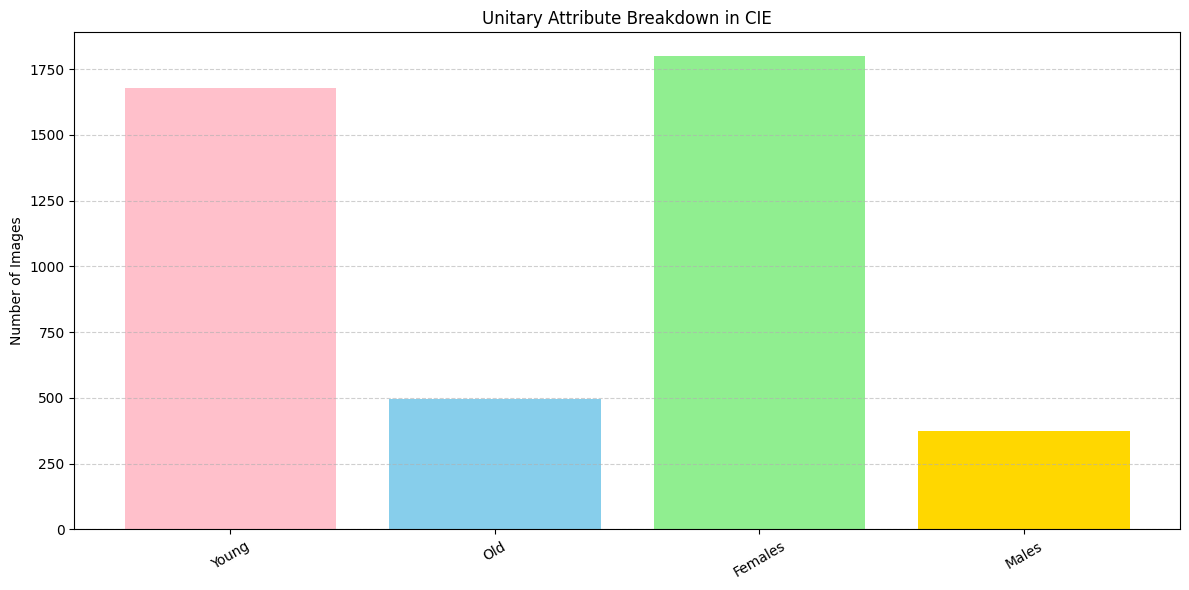

In [26]:
mu.show_cie_eda_unitary_plot(train_cie, att_path)

Young Females: 1445, Young Males: 235, Old Males: 140, Old Females: 355


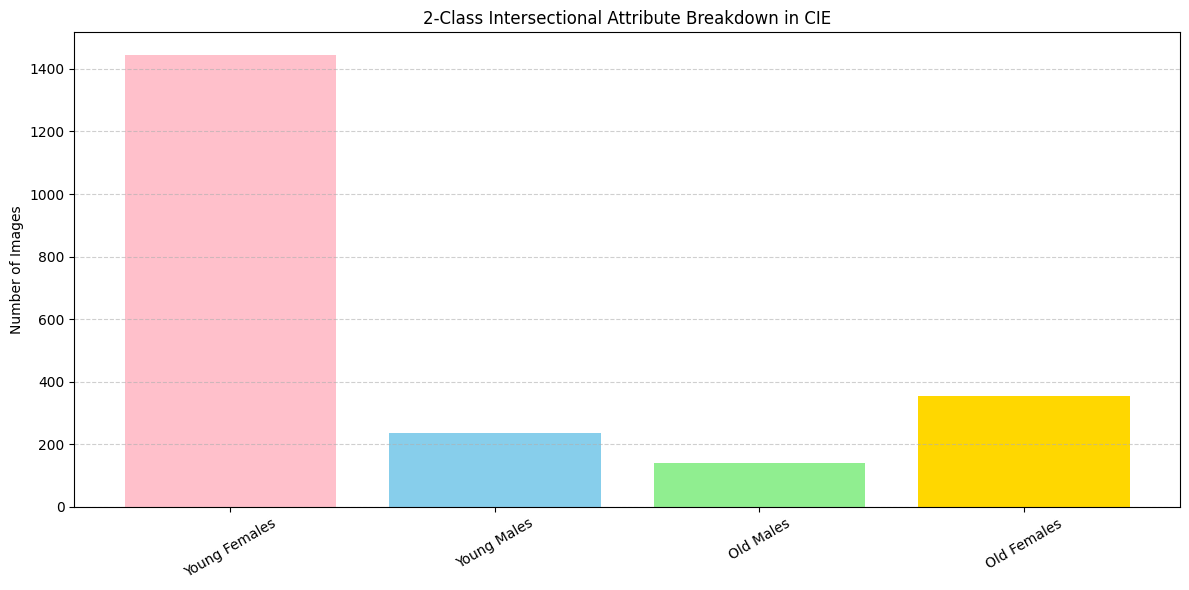

In [27]:
mu.show_cie_eda_inter_plot(train_cie, att_path)

Non-Blonde Young: NBY
Non-Blonde Female: NBF
Non-Blonde Male: NBM
Non-Blonde Old: NBO
Blonde Female: BF
Blonde Young: BY
Blonde Old: BO
Blonde Male: BM
NBY: 641, NBF: 738, NBM: 89, NBO: 186, BF: 1062, BY: 1039, BO: 309, BM: 286


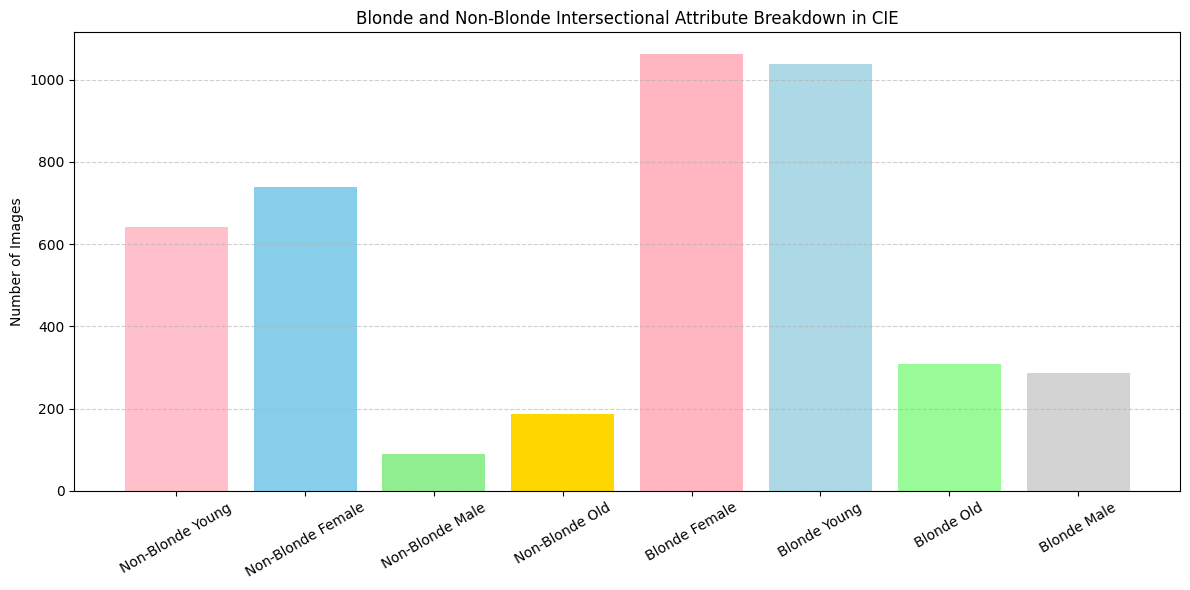

In [28]:
mu.show_cie_eda_blonde_inter_plot(train_cie, att_path)

## Full Set

In [29]:
full_cie = mu.get_cie_count(full_model, vit_model, full_loader)

Determining CIEs:
Number of CIEs: 2968


Young: 2284, Old: 684, Females: 2468, Males: 500


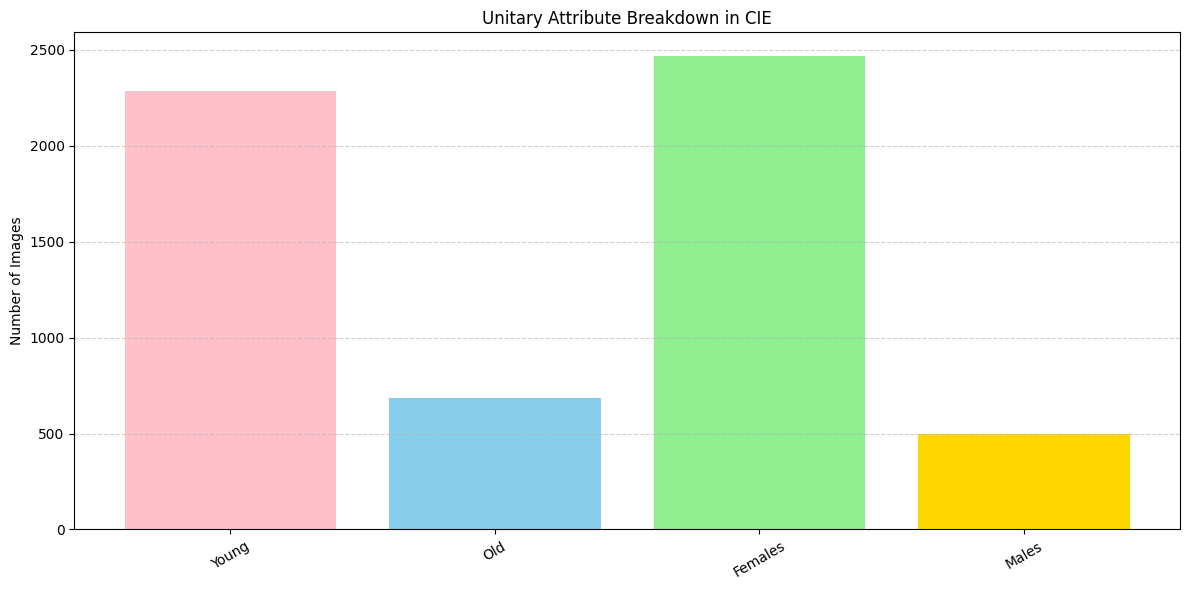

In [30]:
mu.show_cie_eda_unitary_plot(full_cie, att_path)

Young Females: 1976, Young Males: 308, Old Males: 192, Old Females: 492


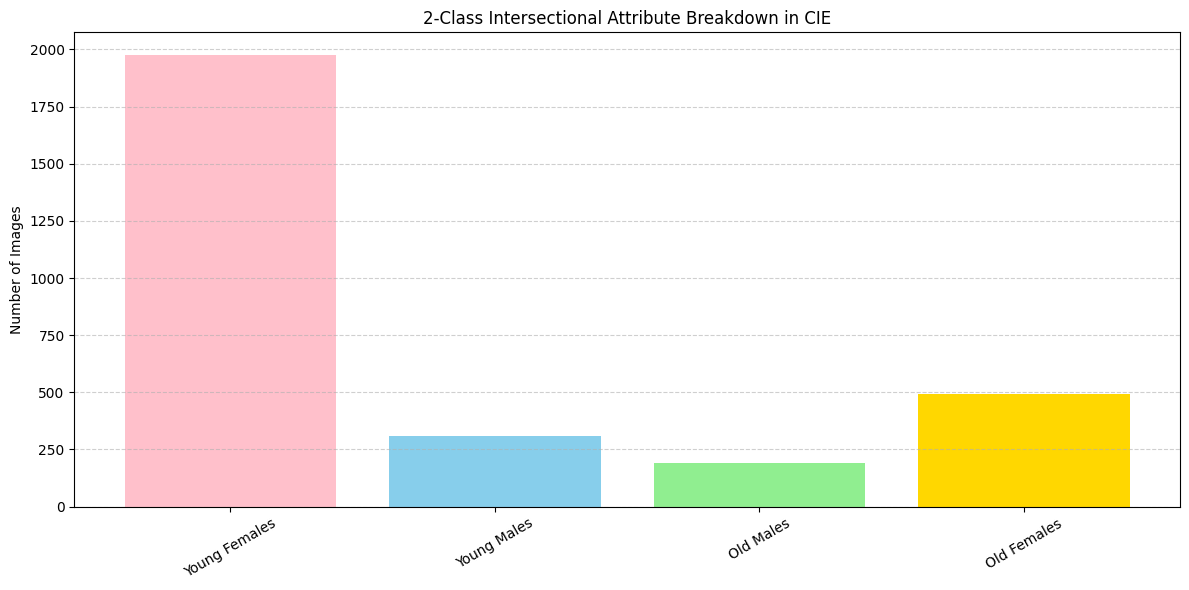

In [31]:
mu.show_cie_eda_inter_plot(full_cie, att_path)

Non-Blonde Young: NBY
Non-Blonde Female: NBF
Non-Blonde Male: NBM
Non-Blonde Old: NBO
Blonde Female: BF
Blonde Young: BY
Blonde Old: BO
Blonde Male: BM
NBY: 938, NBF: 1059, NBM: 174, NBO: 295, BF: 1409, BY: 1346, BO: 389, BM: 326


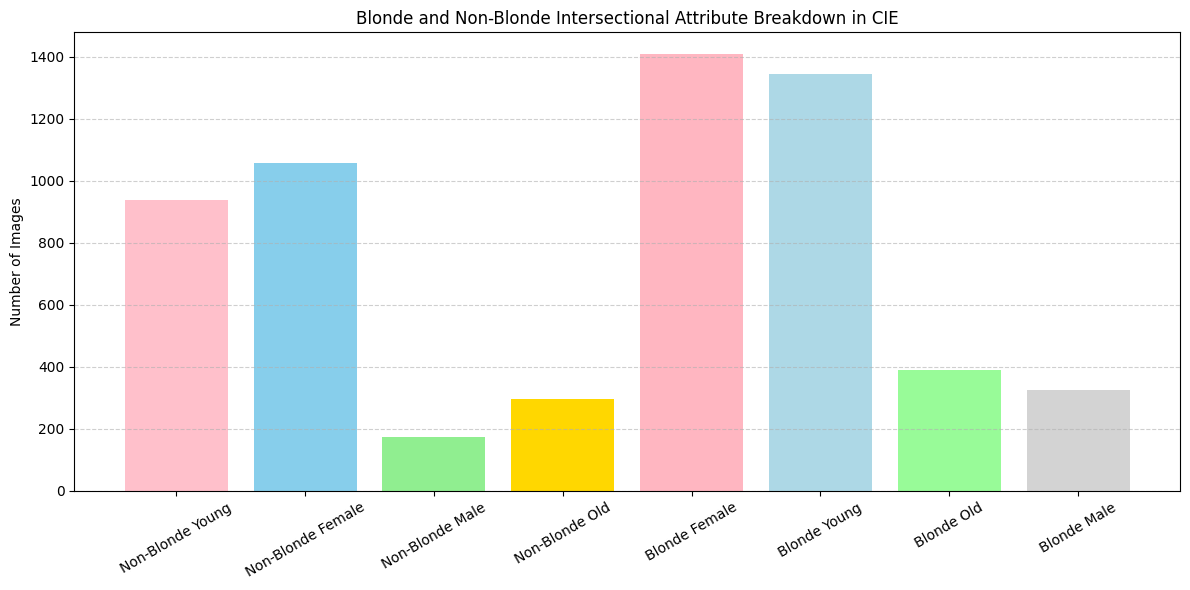

In [32]:
mu.show_cie_eda_blonde_inter_plot(full_cie, att_path)